# Fasterer Python

Pure Python is slow, for two reasons. First, it is an **interpreted language**, which is always less efficient than a compiled language. Second, Python was originally conceived to work on a single thread, to make programming easier. It has a **Global Interpreter Lock (GIL)**, which means that only one python instruction is carried out at a time.

However, there are easy ways to make Python code run **very fast**, circumventing these problems.

First, Python is very good at interfacing with non-Python libraries. This means you can write fast, compiled code in Rust or C++, and then call it from Python. The compiled libraries are exempt from the GIL, meaning that they can do their own threading, as well.

Second, there are a couple forms of parallelism within Python which circumvent the GIL.

## Numpy

Numpy ("Numerical Python") is a fast library for doing all kinds of numerical array operations in Python. It's written in an unholy combination of C++ and Fortran, but as a user, you never have to worry about that!

The golden rule of Numpy is that using numpy operations on numpy arrays is going to be fast, but using Python operations will be slow. For example, iterating over a matrix with for loops is slow, but operating on a matrix with numpy operations is fast.

Let's see an example...

In [1]:
import numpy as np

In [2]:
# ------------------------------------------------------------
# 📝 Exercise 0 – Pure Python vs Numpy
# ------------------------------------------------------------
# First, let's create a Numpy matrix and perform some
# operation to confirm that, indeed, numpy is faster than
# pure python. Mostly we just want to get used to using basic
# numpy operations.
#
# 1) Create a 1024x1024 numpy array, which is 1 along the main
#    diagonal, and 0.1 everywhere else.
# 2) Write a function which adds a constant to each entry in
#    the matrix, using Python for loops to update each entry.
# 3) Write the same function using a one-line numpy operation.
# 4) Use `%time` to compare the running time of the two
#    functions, when run on the matrix from step (1).
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# Make a matrix of random numbers.
mat = 1 # Turn this into a 1024x1024 matrix, as specified above.

def add_constant_python(mat, constant):
    OUT = np.zeros([1024,1024])+0.1
    for i in range(1024):
        for j in range(1024):
            if i == j:
                OUT[i,j] = constant

    return OUT

def add_constant_numpy(mat, constant):
    OUT = np.zeros([1024,1024])+0.1
    OUT = np.fill_diagonal(OUT, constant)
    return OUT


# Test the functions
%time add_constant_python(mat, 1)
%time add_constant_numpy(mat, 1)


CPU times: user 54.8 ms, sys: 7.09 ms, total: 61.9 ms
Wall time: 60.7 ms
CPU times: user 956 μs, sys: 4.06 ms, total: 5.02 ms
Wall time: 4.87 ms


## Building a "Tokenizer" (or, k-means clustering for the young and fancy.)

Now let's do something a bit more meaty...

Lately, working with tokenized vectors is popular - in short, you take some inputs, feed them through a few layers of neural network and turn them into vectors. And then you turn the vectors into discrete objects. How does that work? Clustering! You assign vectors to clusters, and just return the number of the cluster each vector was assigned to.

There are approximately a thousand ways to do clustering, but it turns out that k-means is still surprisingly useful, and more-or-less what people do in practice. So, let's do some k-means clustering.

To do k-means clustering, you need some centroids.  
Then you alternate two steps: 
1) Assign data points to centroids. 
2) Update the centroid as the mean of all the data points assigned to it.

Finally, it's somewhat helpful to keep track of how far each data point is from its assigned centroid - this is the "loss".

Let's implement all of these operations with numpy!

In [4]:
# ------------------------------------------------------------
# 📝 Exercise 1 – Tokenizer
# ------------------------------------------------------------
# To build our tokenizer/k-means clusterer, we'll need three operations:
# a) Generate initial centroids.
# b) Assign data points to clusters.
# c) Update the centroids from the data.
# d) Compute the total distance from the data to the assigned cnetroids.
# 
# Write a function for each of these, following the documentation.
# ------------------------------------------------------------

def generate_initial_centroids(data: np.ndarray, k: int) -> np.ndarray:
  """Generate initial centroids for k-means clustering.

  Par: 1 line of code.

  Args:
    data: The data to cluster.
    k: The number of clusters to generate.
  
  Returns:
    The initial centroids, an array with shape [k, data.shape[1]].
  """
  # find k random indices of data matrix to generate initial centroids
  ix = np.random.choice( len(data), size=k, replace=False )
  init_centroids = data[ix]
  return init_centroids
  

def assign_to_clusters(data: np.ndarray, centroids: np.ndarray) -> np.ndarray:
  """Assign data points to clusters.

  Par: 2 lines of code.

  Args:
    data: The data to cluster.
    centroids: The centroids to use for clustering.
  
  Returns:
    Array with shape [data.shape[0],] of cluster assigments.
  """
  distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
  cluster_index = np.argmin(distances, axis=1)
  return cluster_index


def update_centroids(data: np.ndarray, centroids: np.ndarray) -> np.ndarray:
  """Update the centroids to be the mean of the data points in each cluster.

  Par: 4 lines of code.

  Args:
    data: The data to cluster.
    centroids: The centroids to use for clustering.
  
  Returns:
    The updated centroids.
  """
  assignments = assign_to_clusters(data, centroids)
  k = centroids.shape[0]
  new_centroids = np.array([data[assignments == i].mean(axis=0) for i in range(k)])
  return new_centroids


def reconstruction_loss(data: np.ndarray, centroids: np.ndarray) -> float:
  """Compute the mean distance to the closest centroid.
  
  Par: 2 lines of code.

  Args:
    data: The data to cluster.
    centroids: The centroids to use for clustering.
  
  Returns:
    The mean distance to the closest centroid.
  """
  assignments = assign_to_clusters(data, centroids)
  return np.mean(np.linalg.norm(data - centroids[assignments], axis=1))
  

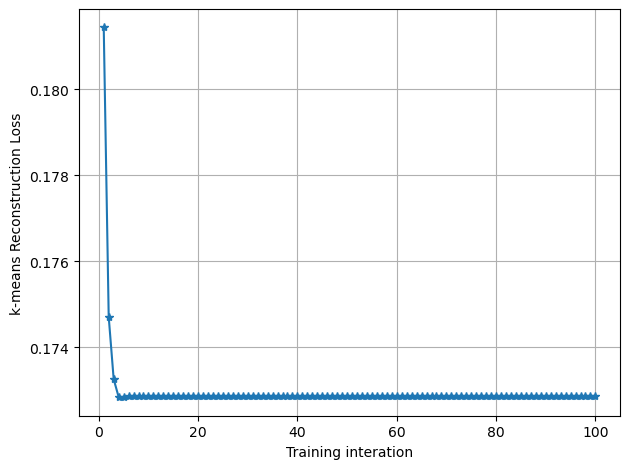

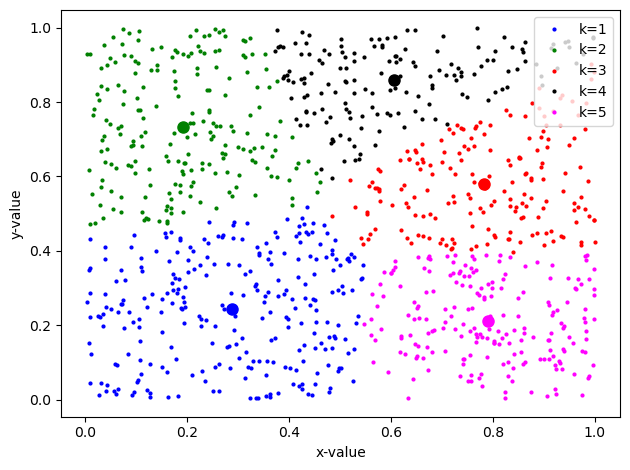

In [6]:
# ------------------------------------------------------------
# 📝 Exercise 1.5 – Tokenizer
# ------------------------------------------------------------
# Now let's generate some data and train the tokenizer.
# Write a loop which continuously improves the centroids.
# ------------------------------------------------------------

import matplotlib.pyplot as plt

# Generate a random matrix of 1024 2-dimensional points.
# data = ...
data = np.random.rand(1024, 2)

# Get the initial centroids.
k = 5
centroids = generate_initial_centroids(data, k)

# 1) Write a /training loop/ - each step, update the centroids and measure
# the reconstruction loss. (100 steps should be plenty.)
# 2) Store the reconstruction loss at each step in an array.
nsteps = 100
recon_loss = np.zeros([nsteps])+np.nan
for i in range(nsteps):
    centroids = update_centroids(data, centroids)
    recon_loss[i] = reconstruction_loss(data, centroids)

# 3) Use plt.plot to plot the reconstruction loss.
plt.figure()
plt.plot(np.arange(1,101,1), recon_loss, '-*')
plt.xlabel('Training interation')
plt.ylabel('k-means Reconstruction Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Use plt.scatter to plot the data and the centroids. Make it look nice.
#    (Hint: 'alpha' can be used to make things transparent, 'c' can be used to 
#    to set a color for each point. The 'marker' and 'size' options might also
#    be helpful...)

clustered_data = assign_to_clusters(data, centroids)

plt.figure()
colors = ['blue', 'green', 'red', 'black', 'magenta']
for i in range(k):
    ixc = np.where(clustered_data == i)[0]
    plt.plot(data[ixc,0], data[ixc,1], 'o', color=colors[i], markersize=2, label=("k=%s" % (i+1)))
    plt.plot(centroids[i,0], centroids[i,1], 'o', color=colors[i], markersize=8)
plt.xlabel('x-value')
plt.ylabel('y-value')
plt.legend()
plt.tight_layout()
plt.show()


Extra challenges...

1) Usually, you can't fit all the data in memory. In that case, you want to do *partial updates* of the cluster centroids. Change the `update_centroids` to take a step-size parameter. Replace each centroid with a weighted average of the current centroid and the mean of the points assigned to the centroid.

2) A problem for k-means clustering on real data is 'dead' centroids. Come up with a rule to replace centroids which haven't been used in a while with a 'fresh' centroid.

3) (Advanced!) When you have high-dimensional data, you need more centroids to represent the data. When you have lots of centroids, things slow down. What to do?? In *product quantization*, you break a vector into parts and apply k-means to each subvector. Then for any vector, it gets assigned a cluster for each sub-vector. Create a collection of centroids with shape `[K, P, N/P]`, and update your algorithm to train centroids for all of the sub-vectors. Try to stick to Numpy operations as much as possible!

## Randomness in numpy

To get the hang of using generators and random numbers in numpy, let's make a synthetic data generator.

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 2 – Random data generator
# ------------------------------------------------------------
# Write a generator which produces batches of random 2D points.
# ------------------------------------------------------------
from typing import Generator

def random_gaussian_data_generator(
    batch_size: int, 
    mu: np.ndarray,
    sigma: np.ndarray) -> Generator[np.ndarray, None, None]:
  """Generate random data from a Gaussian distribution.

  Args:
    batch_size: The number of points to generate.
    mu: The mean of the distribution with shape [D].
    sigma: The standard deviation of the distribution with shape [D].
  
  Yields:
    A batch of random data points.
  """
  raise NotImplementedError

In [ ]:
# ------------------------------------------------------------
# 📝 Exercise 2 Challenge – Random data generator
# ------------------------------------------------------------
# Write a generator which produces batches of random 2D points
# from a mixture of Gaussians distribution.
# The mixture of Gaussians is a weighted sum of multiple
# Gaussian distributions. It is parameterized by a list of means,
# a list of standard deviations, and a list of weights pi which
# sum to 1.
# ------------------------------------------------------------

def random_mixture_of_gaussians_data_generator(
    batch_size: int, 
    mus: np.ndarray,
    sigmas: np.ndarray,
    pis: np.ndarray) -> Generator[np.ndarray, None, None]:
  """Generate random data from a mixture of Gaussians distribution.

  Args:
    batch_size: The number of points to generate.
    mus: The means of the distributions with shape [K, D].
    sigmas: The standard deviations of the distributions with shape [K, D].
    pis: The weights of the distributions with shape [K].
  
  Yields:
    A batch of random data points.
  """
  raise NotImplementedError